In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-faj124nf because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_closure():
    plt.show()
    #plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [27]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
print(all_points.shape)
all_poses = all_points.reshape(-1,8)

# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
# scaling term doesn't affect time, so don't use time in calculation

mean = np.mean(all_poses, axis=0)
mean[0] = 0 # don't scale time
variance = np.var(all_poses[:,1:], axis=0) # don't scale time
print(mean)
print(variance)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

print(f"position_scaling of {position_scaling}, rot_scaling of {rotation_scaling}")

We found 155 pickup attempts
(155, 64, 8)
[ 0.          0.00227658 -0.00117697  0.0121782  -0.04935249  0.37343377
 -0.89429268 -0.01921521]
[2.63014114e-05 3.40430938e-05 1.00819967e-04 7.90561700e-03
 3.18947674e-02 7.03375426e-03 1.11414372e-02]
std of:  0.17859106200728153
position_scaling of 5.599384363139225, rot_scaling of 0.895901498102276


In [5]:
def print_to_csv(mean):
    string = ""
    for i,m in enumerate(mean):
        string += "%0.8f" % m
        if i < len(mean)-1:
            string+= ","
    return string
print(f"\
      mean = np.array(({print_to_csv(mean[1:])}))\n\
      ps = {position_scaling}\n\
      rs = {rotation_scaling}\n")
def scale_dataset(input_points):
    points = input_points - mean
    poss = position_scaling
    rts = rotation_scaling
    points = (points * np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    return points

def unscale_poses(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean[1:]
    return points 
    
def unscale_dataset(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean
    return points

      mean = np.array((0.00227658,-0.00117697,0.01217820,-0.04935249,0.37343377,-0.89429268,-0.01921521))
      ps = 5.599384363139225
      rs = 0.895901498102276



In [6]:
dataset = scale_dataset(all_points)
t_all_points = torch.tensor(dataset,dtype=torch.float32)

## 2D VAE Fit to Dataset

In [7]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [8]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [9]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [10]:
testname = f"trainedmodels/{foodname}_"

In [11]:
all_models = []

for curvreg in [0.001,0,0.0001,0.0005]:
    for beta in [0.00001,0.0001,0.001,0.01]:
        for latentdim in [3]:
            for epsilon_scale_start in [1]:
                try:
                    savedir_pattern  = f'{testname}lat{latentdim}_curvreg{curvreg}_beta{beta}_*'

                    filenames = glob.glob(savedir_pattern)
                    #print(len(filenames))
                    for filename in filenames:
                        if 'epoch' in filename:
                            continue
                        try:
                            #print(filename)
                            textfilename = glob.glob(filename + "/model_type.txt")[0]
                            #print(textfilename)
                            all_models.append(filename)
                        except:
                            continue
                except:
                    continue

In [12]:
all_models = ['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']
#all_models = [f'trainedmodels/{foodname}_lat3_curvreg0.001_beta0.001_20220216-113851']
all_models

['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']

In [13]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [14]:
def make_start_grid_points(*, num_dims = None, t = 0, **kwargs):
    if num_dims is None:
        raise Exception("Switched this method to require num_dims as a named arg, sorry")
    num_few = 5
    num_med = 5
    num_many = 300
    pts = []
    if num_dims == 4:
        # expects args to contain ymin, ymax, zmin, zmax
        xmin = kwargs["xmin"]
        xmax = kwargs["xmax"]
        ymin = kwargs["ymin"]
        ymax = kwargs["ymax"]
        zmin = kwargs["zmin"]
        zmax = kwargs["zmax"]
        for x in np.linspace(xmin, xmax, num_few):
            for y in np.linspace(ymin, ymax, num_med):
                for z in np.linspace(zmin, zmax, num_many):
                    pts.append((t,x,y,z))
        for x in np.linspace(xmin, xmax, num_few):
            for y in np.linspace(ymin, ymax, num_many):
                for z in np.linspace(zmin, zmax, num_med):
                    pts.append((t,x,y,z))
        for x in np.linspace(xmin, xmax, num_many):
            for y in np.linspace(ymin, ymax, num_med):
                for z in np.linspace(zmin, zmax, num_med):
                    pts.append((t,x,y,z))
        return np.array(pts)

In [15]:
def get_scale(data, buffer=0.1):
    valrange = np.max(data) - np.min(data)
    return(np.min(data)-buffer*valrange,np.max(data)+buffer*valrange,)

In [16]:
latent_lim_values = np.array((2.,2,2))

In [17]:
def threedcolormap(pt, minval=-2, maxval=2):
    scaled_pt = (pt - minval)/(maxval-minval)
    cs = (scaled_pt[:,1:2] * np.array((1,0,-1)).reshape(1,3) + 
          scaled_pt[:,2:3] * np.array((0,1,0)).reshape(1,3) +
          np.array((0,0,1)).reshape(1,3))
    cs = cs * (scaled_pt[:,3:4]/2+0.5)
    return cs

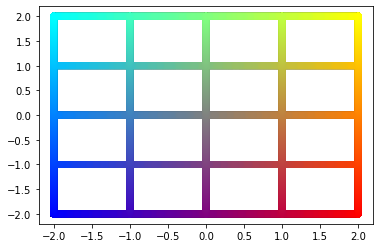

In [18]:
xlow,ylow,zlow = latent_lim_values
xhigh,yhigh,zhigh = -latent_lim_values
latent_dim=3
sweep = make_start_grid_points(t = 0,num_dims = latent_dim+1,xmin=xlow,xmax=xhigh,ymin=ylow,ymax=yhigh,zmin=zlow,zmax=zhigh)
colors = threedcolormap(sweep)
sumcolors = np.sum(colors,axis=1)
nice_color_order = np.argsort(sumcolors)
plt.scatter(sweep[nice_color_order,1],sweep[nice_color_order,2],c=colors[nice_color_order])

In [19]:
def plot_start_pose(modelname, ax,plot_axes,t):
    loaded_mod = lm.load_model(modelname)
    latent_dim = loaded_mod.latent_dim
    loaded_vae = loaded_mod
    #x,mu,logvar, noisy_mu, t
    embeds = np.array([loaded_vae.forward(t_all_points[i,:1,1:], t_all_points[i,:1,:1])[1].detach().numpy() for i in range(len(t_all_points))])
    embeds = embeds[:,0,:]
    #xlow,ylow,zlow = np.min(embeds,axis=0)
    #xhigh,yhigh,zhigh = np.max(embeds,axis=0)
    
    xlow,ylow,zlow = latent_lim_values
    xhigh,yhigh,zhigh = -latent_lim_values
    print(xlow, xhigh,ylow,zlow,yhigh,zhigh)
    sweep = make_start_grid_points(t = t,num_dims = latent_dim+1,xmin=xlow,xmax=xhigh,ymin=ylow,ymax=yhigh,zmin=zlow,zmax=zhigh)
    colors = threedcolormap(sweep)
    print(colors.shape)
    sumcolors = np.sum(colors,axis=1)
    nice_color_order = np.argsort(sumcolors)
    print(nice_color_order.shape)
    sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                     torch.tensor(sweep[:,:1], dtype=torch.float32),
                                    )
    sweepdecodedx=unscale_poses(sweepdecodedx.detach().cpu().numpy())
    sweepdecodedt=sweepdecodedt.detach().cpu().numpy()
    p=ax.scatter(sweepdecodedx[nice_color_order,plot_axes[0]], sweepdecodedx[nice_color_order,plot_axes[1]],  alpha=1,c=colors[nice_color_order,:])
    ax.scatter(all_points[:,int(t*64),plot_axes[0]+1], all_points[:,int(t*64),plot_axes[1]+1],  alpha=0.5,color="k",s=5);

In [20]:
def plot_start_pose3d(modelname, ax,plot_axes,t):
    loaded_mod = lm.load_model(modelname)
    latent_dim = loaded_mod.latent_dim
    loaded_vae = loaded_mod
    #x,mu,logvar, noisy_mu, t
    embeds = np.array([loaded_vae.forward(t_all_points[i,:1,1:], t_all_points[i,:1,:1])[1].detach().numpy() for i in range(len(t_all_points))])
    embeds = embeds[:,0,:]
    #xlow,ylow,zlow = np.min(embeds,axis=0)
    #xhigh,yhigh,zhigh = np.max(embeds,axis=0)
    
    xlow,ylow,zlow = latent_lim_values
    xhigh,yhigh,zhigh = -latent_lim_values
    print(xlow, xhigh,ylow,zlow,yhigh,zhigh)
    sweep = make_start_grid_points(t = t,num_dims = latent_dim+1,xmin=xlow,xmax=xhigh,ymin=ylow,ymax=yhigh,zmin=zlow,zmax=zhigh)
    colors = threedcolormap(sweep)
    print(colors.shape)
    sumcolors = np.sum(colors,axis=1)
    nice_color_order = np.argsort(sumcolors)
    print(nice_color_order.shape)
    sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                     torch.tensor(sweep[:,:1], dtype=torch.float32),
                                    )
    sweepdecodedx=unscale_poses(sweepdecodedx.detach().cpu().numpy())
    sweepdecodedt=sweepdecodedt.detach().cpu().numpy()
    p=ax.scatter(sweepdecodedx[nice_color_order,plot_axes[0]], sweepdecodedx[nice_color_order,plot_axes[1]], sweepdecodedx[nice_color_order,plot_axes[2]],  alpha=1,c=colors[nice_color_order,:])
    ax.scatter(all_points[:,int(t*64),plot_axes[0]+1], all_points[:,int(t*64),plot_axes[1]+1],all_points[:,int(t*64),plot_axes[2]+1],  alpha=0.5,color="k",s=5);

In [21]:
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


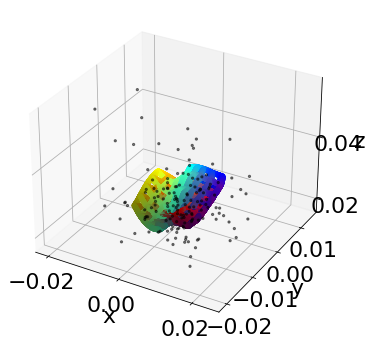

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


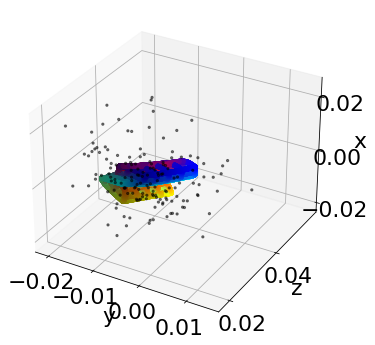

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


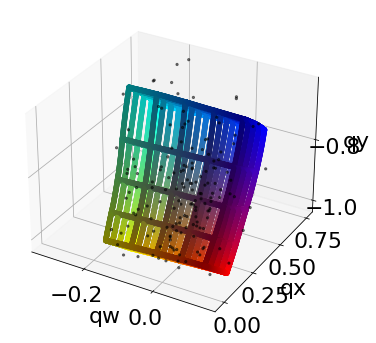

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


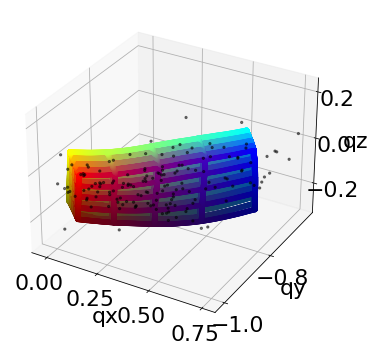

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


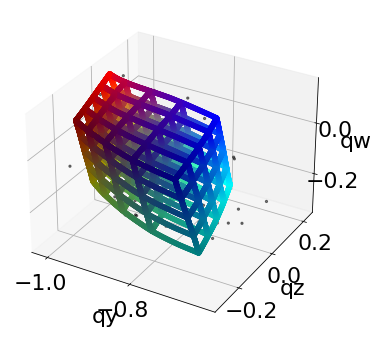

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


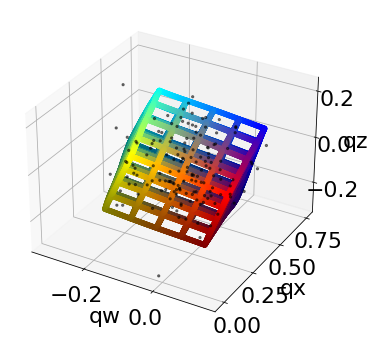

In [22]:
ax_names = ["x","y","z","qw","qx","qy","qz"]
for j in range(len(all_models)):
    for axinds in [[0,1,2],[1,2,0],[3,4,5],[4,5,6],[5,6,3],[3,4,6]]:
        print(all_models[j])
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1,projection='3d')
        plot_start_pose3d(all_models[j], ax,axinds,t=0)
        plt.xlabel(ax_names[axinds[0]])
        plt.ylabel(ax_names[axinds[1]])
        ax.set_zlabel(ax_names[axinds[2]])
        fig.savefig(f"images/{foodname}_fulltraj_initfit_curvvae_{ax_names[axinds[0]]}_{ax_names[axinds[1]]}_{ax_names[axinds[2]]}.png",
                  bbox_inches = 'tight')
        plot_closure()

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


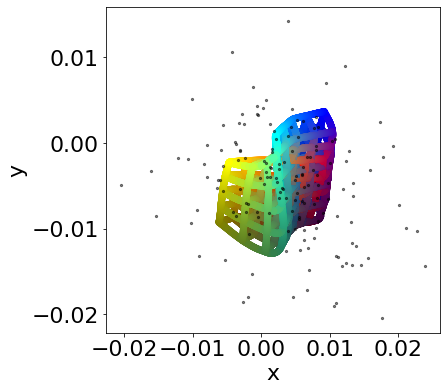

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


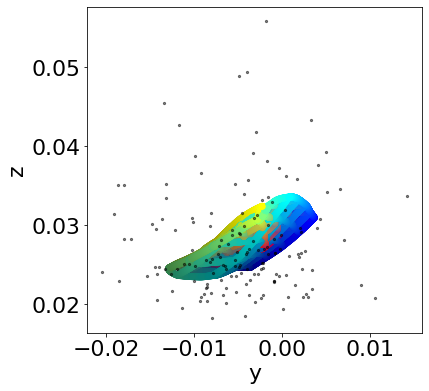

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


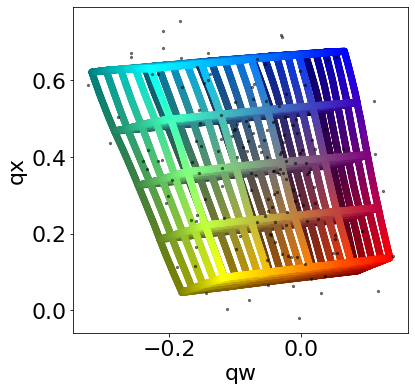

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


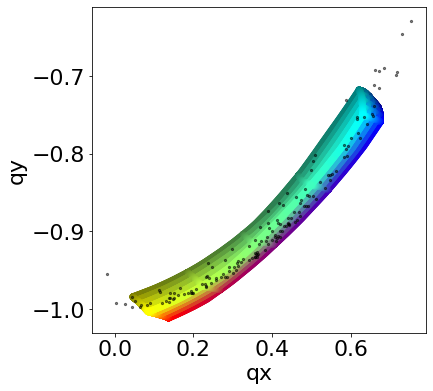

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


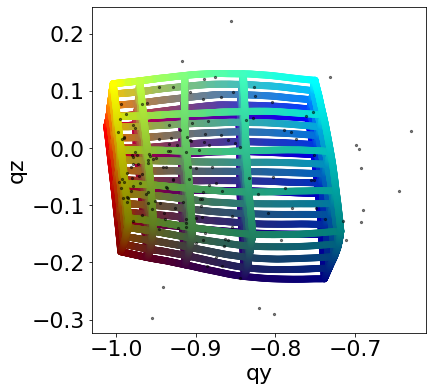

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
2.0 -2.0 2.0 2.0 -2.0 -2.0
(22500, 3)
(22500,)


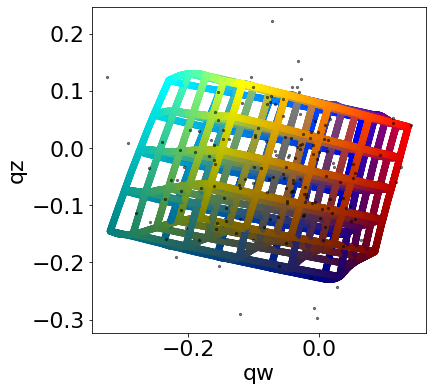

In [23]:
ax_names = ["x","y","z","qw","qx","qy","qz"]
for j in range(len(all_models)):
    for axinds in [[0,1],[1,2],[3,4],[4,5],[5,6],[3,6]]:
        print(all_models[j])
        fig = plt.figure(figsize=(6,6),)
        ax = fig.add_subplot(1,1,1)
        plot_start_pose(all_models[j], ax,axinds,t=0)
        plt.xlabel(ax_names[axinds[0]])
        plt.ylabel(ax_names[axinds[1]])
        fig.savefig(f"images/{foodname}_fulltraj_initfit_curvvae_{ax_names[axinds[0]]}_{ax_names[axinds[1]]}.png",
                  bbox_inches = 'tight')
        plot_closure()

In [24]:
def make_linear_sweep(lin_start, lin_end):
    lin_start = np.array(lin_start)
    lin_end = np.array(lin_end)
    num_few = 5
    num_many=64
    pts = []
    tmin = 0
    tmax = 1
    for lambdaval in np.linspace(0, 1, num_few):
        for t in np.linspace(tmin, tmax, num_many,endpoint=False):
            next_to_add = np.array([t] + ((lin_end-lin_start)*lambdaval + lin_start).tolist())
            pts.append(next_to_add)
    return np.array(pts)

In [25]:
def make_grid_trajectories(limval):
    num_few = 3
    num_med = 50
    num_many = 100
    pts = []
    
    # expects args to contain ymin, ymax, zmin, zmax
    xmin = -limval
    xmax = limval
    ymin = -limval
    ymax = limval
    zmin = -limval
    zmax = limval
    z=0
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_med):
            for t in np.linspace(0, 63./64, num_many):
                pts.append((t,z,y,x))
    #for x in np.linspace(xmin, xmax, num_med):
    #    for y in np.linspace(ymin, ymax, num_few):
    #        for t in np.linspace(0, 63./64, num_many):
    #            pts.append((t,x,y,z))
    return np.array(pts)

In [26]:
latent_lim_values = np.array()

TypeError: Required argument 'object' (pos 1) not found

In [ ]:

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1,projection='3d')
xlow,ylow,zlow = (-3,-3,-3)
xhigh,yhigh,zhigh = (3,3,3)
latent_dim=3
sweep = make_start_grid_points(t = 0,num_dims = latent_dim+1,xmin=xlow,xmax=xhigh,ymin=ylow,ymax=yhigh,zmin=zlow,zmax=zhigh)
colors = threedcolormap(sweep,-3,3)
sumcolors = np.sum(colors,axis=1)
nice_color_order = np.argsort(sumcolors)
ax.scatter(sweep[nice_color_order,1],sweep[nice_color_order,2],sweep[nice_color_order,3],c=colors[nice_color_order])
ax.set_xlabel("Latent 1",labelpad=15)
ax.set_ylabel("Latent 2",labelpad=15)
ax.set_zlabel("Latent 3",labelpad=15)
ax.xaxis.set_ticks(np.arange(-3, 4, 1))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)
plot_closure()

In [ ]:
ax_names = ["x","y","z","qw","qx","qy","qz"]
for modelstring in all_models:
        print(modelstring)
        loaded_mod = lm.load_model(modelstring)
        loaded_vae = loaded_mod
        latent_dim = loaded_mod.latent_dim
        #x,mu,logvar, noiasy_mu, t
        embeds = np.array([loaded_vae.forward(t_all_points[i,:,1:], t_all_points[i,:,:1])[3].detach().numpy() for i in range(len(t_all_points))])
        embeds = embeds[:,0,:]
        print(embeds.shape)
        #latmins = np.min(embeds,axis=0)
        #latmaxs = np.max(embeds,axis=0)
        latmins = latent_lim_values
        latmaxs = -latent_lim_values
        print(latmins,latmaxs)

        sweep = make_grid_trajectories(latent_lim_values[0])
        sweep_reshaped = sweep.reshape(-1,100,4)
        #print(sweep)
        colors = threedcolormap(sweep_reshaped[:,0,:],minval=-3,maxval=3)
        print("colors shape is", colors.shape)
        sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                         torch.tensor(sweep[:,:1], dtype=torch.float32),
                                        )
        sweepdecodedx=sweepdecodedx.detach().cpu().numpy()
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedx = unscale_poses(sweepdecodedx)
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedt=sweepdecodedt.detach().cpu().numpy()     
        
        sumcolors = np.sum(colors,axis=1)
        nice_color_order = np.argsort(sumcolors)
        
        for yaxis,zaxis in [(0,1),(1,2),(3,4),(3,5),(3,6)]:#
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(projection='3d')
            ax.tick_params(axis='y', which='major', pad=15)
            ax.tick_params(axis='z', which='major', pad=15)
            plotsweepdecodedt = sweepdecodedt.reshape(-1,100)
            plotsweepdecodedy = sweepdecodedx[:,yaxis].reshape(-1,100)
            plotsweepdecodedz = sweepdecodedx[:,zaxis].reshape(-1,100)
            for (ycoord, ylabel) in [(0,"-3"),(49,"3")]:
                for (xcoord, xlabel) in [(0,"-3"),(100,"3")]:
                    ax.text(plotsweepdecodedt[xcoord+ycoord,0],
                            plotsweepdecodedy[xcoord+ycoord,0],
                            plotsweepdecodedz[xcoord+ycoord,0],f"({sweep[xcoord+ycoord]})",
                            horizontalalignment='right' if ycoord == 49 else 'left',
                            verticalalignment='bottom' if xcoord == 100 else 'top')
                    ax.scatter(plotsweepdecodedt[xcoord+ycoord,0],
                            plotsweepdecodedy[xcoord+ycoord,0],
                            plotsweepdecodedz[xcoord+ycoord,0],c="k",s=20)
            print("colors shape is", colors.shape)
            for indx in nice_color_order:
                p=ax.plot(plotsweepdecodedt[indx], plotsweepdecodedy[indx], plotsweepdecodedz[indx], alpha=1,c=colors[indx])
            for indx in range(len(all_points)):
                p=ax.plot(all_points[indx,:,0].T,all_points[indx,:,yaxis+1].T,all_points[indx,:,zaxis+1].T, alpha=0.1,c="k")
            ax.set_ylabel(ax_names[yaxis], labelpad=30)
            ax.set_zlabel(ax_names[zaxis], labelpad=30)
            ax.set_xlabel("time (scaled)", labelpad=20)
            ax.view_init(azim=240,elev=30)
            plt.savefig(f"images/{foodname}modeled{ax_names[yaxis]}{ax_names[yaxis]}OverTime.jpeg")
            plot_closure()

In [ ]:
ax_names = ["x","y","z","qw","qx","qy","qz"]
for sweepdir in [np.array((0,3,0)),np.array((0,0,3)),np.array((3,0,0))]:
    for modelstring in all_models:
        print(modelstring)
        loaded_mod = lm.load_model(modelstring)
        loaded_vae = loaded_mod
        latent_dim = loaded_mod.latent_dim
        #x,mu,logvar, noiasy_mu, t
        embeds = np.array([loaded_vae.forward(t_all_points[i,:,1:], t_all_points[i,:,:1])[3].detach().numpy() for i in range(len(t_all_points))])
        embeds = embeds[:,0,:]
        print(embeds.shape)
        #latmins = np.min(embeds,axis=0)
        #latmaxs = np.max(embeds,axis=0)
        latmins = latent_lim_values
        latmaxs = -latent_lim_values
        print(latmins,latmaxs)

        sweep = make_linear_sweep(-sweepdir,sweepdir)
        #print(sweep)
        colors = threedcolormap(sweep,minval=-3,maxval=3)
        print(colors.shape)
        sumcolors = np.sum(colors,axis=1)
        nice_color_order = np.argsort(sumcolors)
        sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                         torch.tensor(sweep[:,:1], dtype=torch.float32),
                                        )
        sweepdecodedx=sweepdecodedx.detach().cpu().numpy()
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedx = unscale_poses(sweepdecodedx)
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedt=sweepdecodedt.detach().cpu().numpy()       
        
        plotsweepdecodedt = sweepdecodedt.reshape(-1,64)
        plotcolors = colors.reshape(-1,64,3)
        for yaxis in np.arange(7):
            plotsweepdecodedy = sweepdecodedx[:,yaxis].reshape(-1,64)
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot()#projection='3d')
            for i in range(len(plotsweepdecodedt)):
                p=ax.plot(plotsweepdecodedt[i],plotsweepdecodedy[i],  alpha=0.8,color=plotcolors[i][0],linewidth=5)
            p=ax.plot(all_points[:,:,0].T,all_points[:,:,yaxis+1].T, alpha=0.1,c="k")
            ax.set_ylabel(ax_names[yaxis])
            ax.set_xlabel("time (scaled)")
            plt.savefig(f"images/{foodname}modeled{ax_names[yaxis]}OverTime{sweepdir}.jpeg")
            plot_closure()